In [28]:
audio_path = "/Users/fwtrv/Downloads/Jump Up, Super Star! NDC Festival Edition.wav"
lyrics_path = "/Users/fwtrv/Desktop/ECE-GY 7123/Final/Jump Up, Super Star! NDC Festival Edition.txt"
save_track_vocal_path = "track_vocal.wav"
# lang="zh-CN"
lang = "en-US"

In [29]:
# Library
import torch
import torchaudio
import librosa
import soundfile
import IPython
import matplotlib.pyplot as plt

import torchaudio.functional as F

In [30]:
# Select device
if torch.cuda.is_available():
    device = "cuda"     # CUDA
# elif torch.backends.mps.is_available(): 
#     device = torch.device('mps')    # Apple Sillicon
else:
    device = torch.device("cpu")    # CPU

print("Device Selected:", device)

Device Selected: cpu


# Audio File Preprocessing - Extract Vocals from Audio File

In [31]:
# Extract Vocals from Audio File
from demucs.pretrained import get_model
from demucs.apply import apply_model
from demucs.separate import load_track
ORIGINAL_SR = 44100
TARGET_SR = 16000
preprocessed = True

if not preprocessed:
    # Choose Demucs Model for Vocals Extraction
    demucs_model = get_model(name="htdemucs", repo=None)
    demucs_model.to(device)
    demucs_model.eval()
    vocals_source_idx = demucs_model.sources.index("vocals")
    sample_rate = demucs_model.samplerate

    # Load Aduio Track
    audio_track = load_track(audio_path, 2, sample_rate)

    # Extract Vocal
    ref = audio_track.mean(0)
    audio_track_nor = (audio_track - ref.mean()) / ref.std() # Normalization
    with torch.no_grad():
        sources = apply_model(demucs_model, audio_track_nor[None], device=device, shifts=1, split=True, overlap=0.25, progress=False)
    track_vocal = sources[0][vocals_source_idx].cpu().numpy()[0, ...]

    # Post-processing
    track_vocal = librosa.resample(track_vocal, orig_sr=ORIGINAL_SR, target_sr=TARGET_SR)

    # Write to Output
    soundfile.write(save_track_vocal_path, track_vocal, TARGET_SR)


In [32]:
import re
waveform, _ = torchaudio.load("track_vocal.wav")
number_to_word = {
    '0': ' zero ',
    '1': ' one ',
    '2': ' two ',
    '3': ' three ',
    '4': ' four ',
    '5': ' five ',
    '6': ' six ',
    '7': ' seven ',
    '8': ' eight ',
    '9': ' nine '
}
def replace_numbers(match):
    return number_to_word[match.group()]

# Get plain lyrics from file
with open(lyrics_path, 'r') as file:
    lyrics_plain = file.read()
    lyrics_processed = lyrics_plain.lower()
    
lyrics_processed = re.sub(r'\d', replace_numbers, lyrics_processed)
TRANSCRIPT = lyrics_processed = re.findall(r"\b\w+(?:'\w+)?\b", lyrics_processed)
TRANSCRIPT

['here',
 'we',
 'go',
 'off',
 'the',
 'rails',
 "don't",
 'you',
 'know',
 "it's",
 'time',
 'to',
 'raise',
 'our',
 'sails',
 "it's",
 'freedom',
 'like',
 'you',
 'never',
 'knew',
 "don't",
 'need',
 'bags',
 'or',
 'a',
 'pass',
 'say',
 'the',
 'word',
 "i'll",
 'be',
 'there',
 'in',
 'a',
 'flash',
 'you',
 'could',
 'say',
 'my',
 'hat',
 'is',
 'off',
 'to',
 'you',
 'oh',
 'we',
 'can',
 'zoom',
 'all',
 'the',
 'way',
 'to',
 'the',
 'moon',
 'from',
 'this',
 'great',
 'wide',
 'wacky',
 'world',
 'jump',
 'with',
 'me',
 'grab',
 'coins',
 'with',
 'me',
 'oh',
 'yeah',
 "it's",
 'time',
 'to',
 'jump',
 'up',
 'in',
 'the',
 'air',
 'jump',
 'up',
 'in',
 'the',
 'air',
 'jump',
 'up',
 "don't",
 'be',
 'scared',
 'jump',
 'up',
 "don't",
 'be',
 'scared',
 'jump',
 'up',
 'and',
 'your',
 'cares',
 'will',
 'soar',
 'away',
 'and',
 'if',
 'the',
 'dark',
 'clouds',
 'start',
 'to',
 'swirl',
 'dark',
 'clouds',
 'start',
 'to',
 'swirl',
 "don't",
 'fear',
 "don't",


# Generating emissions

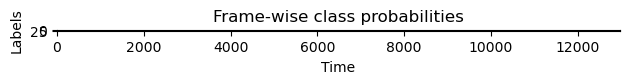

In [33]:
bundle = torchaudio.pipelines.MMS_FA

model = bundle.get_model(with_star=False).to(device)
with torch.inference_mode():
    emission, _ = model(waveform.to(device))

def plot_emission(emission):
    fig, ax = plt.subplots()
    ax.imshow(emission.cpu().T)
    ax.set_title("Frame-wise class probabilities")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.tight_layout()


plot_emission(emission[0])

# Tokenize the transcript

In [34]:
LABELS = bundle.get_labels(star=None)
DICTIONARY = bundle.get_dict(star=None)
for k, v in DICTIONARY.items():
    print(f"{k}: {v}")

tokenized_transcript = [DICTIONARY[c] for word in TRANSCRIPT for c in word]

-: 0
a: 1
i: 2
e: 3
n: 4
o: 5
u: 6
t: 7
s: 8
r: 9
m: 10
k: 11
l: 12
d: 13
g: 14
h: 15
y: 16
b: 17
p: 18
w: 19
c: 20
v: 21
j: 22
z: 23
f: 24
': 25
q: 26
x: 27


# Word-level alignments

In [35]:
def unflatten(list_, lengths):
    assert len(list_) == sum(lengths)
    i = 0
    ret = []
    for l in lengths:
        ret.append(list_[i : i + l])
        i += l
    return ret


def align(emission, tokens):
    targets = torch.tensor([tokens], dtype=torch.int32, device=device)
    alignments, scores = F.forced_align(emission, targets, blank=0)

    alignments, scores = alignments[0], scores[0]  # remove batch dimension for simplicity
    scores = scores.exp()  # convert back to probability
    return alignments, scores


aligned_tokens, alignment_scores = align(emission, tokenized_transcript)

token_spans = F.merge_tokens(aligned_tokens, alignment_scores)
word_spans = unflatten(token_spans, [len(word) for word in TRANSCRIPT])

In [36]:
# Compute average score weighted by the span length
def _score(spans):
    return sum(s.score * len(s) for s in spans) / sum(len(s) for s in spans)


def preview_word(waveform, spans, num_frames, transcript, sample_rate=bundle.sample_rate):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * spans[0].start)
    x1 = int(ratio * spans[-1].end)
    print(f"{transcript} ({_score(spans):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)


num_frames = emission.size(1)

In [47]:
sample_rate=bundle.sample_rate
for i in range(len(word_spans)):
    ratio = waveform.size(1) / num_frames
    x0 = int(ratio * word_spans[i][0].start)
    x1 = int(ratio * word_spans[i][-1].end)
    print(f"{TRANSCRIPT[i]} ({_score(word_spans[i]):.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")

here (0.03): 23.662 - 32.002 sec
we (0.29): 32.002 - 32.082 sec
go (0.36): 32.162 - 32.282 sec
off (0.19): 33.083 - 33.203 sec
the (0.45): 33.203 - 33.263 sec
rails (0.49): 33.343 - 33.843 sec
don't (0.01): 33.863 - 34.323 sec
you (0.13): 34.323 - 34.443 sec
know (0.21): 34.463 - 34.723 sec
it's (0.34): 34.983 - 35.143 sec
time (0.20): 35.183 - 35.483 sec
to (0.52): 35.503 - 35.583 sec
raise (0.68): 35.763 - 36.083 sec
our (0.60): 36.123 - 36.203 sec
sails (0.38): 36.283 - 36.823 sec
it's (0.53): 37.323 - 37.463 sec
freedom (0.48): 37.543 - 37.943 sec
like (0.51): 38.023 - 38.463 sec
you (0.54): 38.503 - 38.623 sec
never (0.54): 38.743 - 39.083 sec
knew (0.24): 39.183 - 39.503 sec
don't (0.00): 41.303 - 41.403 sec
need (0.16): 41.403 - 41.543 sec
bags (0.54): 41.583 - 42.023 sec
or (0.30): 42.523 - 42.623 sec
a (0.36): 42.663 - 42.683 sec
pass (0.39): 42.763 - 43.163 sec
say (0.18): 43.583 - 43.703 sec
the (0.04): 43.743 - 43.803 sec
word (0.46): 43.883 - 44.303 sec
i'll (0.10): 44.403